# IMPORTACIÓN LIBRERIAS


In [1]:
import numpy as np
import pandas as pd
from math import *
import math
import matplotlib.pyplot as plt
# from PIL import Image
import seaborn as sns
# import itertools
# import io 
# import plotly.offline as py
#py.init_notebook_mode(connect=True)
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots
# import plotly.figure_factory as ff
import warnings
warnings.filterwarnings('ignore')

# CARGA DE ARCHIVOS

In [2]:
def load_dataset(file_path, file_type=None, separator=None, encoding='utf-8', **kwargs):
    """
    Loads a dataset in different formats, with support for custom separators, encoding, and more options.
    """
    # If the file type is not specified, infer from file extension
    if not file_type:
        file_type = file_path.split('.')[-1].lower()

    # Load according to the file type
    if file_type == 'csv':
        return pd.read_csv(file_path, sep=separator or ',', encoding=encoding, **kwargs)
    elif file_type in ['xls', 'xlsx']:
        return pd.read_excel(file_path, **kwargs)
    elif file_type == 'json':
        return pd.read_json(file_path, encoding=encoding, **kwargs)
    else:
        raise ValueError(f"File format '{file_type}' not supported. Use 'csv', 'excel', or 'json'.")

Se importan todos los archivos csv que se han creado para juntar la info y trabajar con ellos para que salga el documento final para el modelo.

In [7]:
abonados = load_dataset('../data/abonados_final_para_modelo.csv')
servicios_extra = load_dataset('../data/servicios_final.csv')
economia = load_dataset('../data/economia_final.csv')
accesos = load_dataset('../data/resumen_accesos_final.csv')

# PRIMERA PARTE: ABONADOS + SERVICIOS EXTRA

In [65]:
abonados.head()

,IdPersona,Edad,Sexo_Mujer,Churn,AntiguedadAños,TipoUltimoAbono,Irregularidad_ActivoIrregular,Irregularidad_ActivoRegular,Irregularidad_BajaFinalIrregular,Irregularidad_BajaFinalRegular,MesesDesdeUltimoAbono
0,334,82.0,False,0,69.81,AVET,True,False,False,False,175.9
1,452,85.0,False,0,69.00,AVET,False,True,False,False,839.5
2,642,77.0,False,0,67.54,AVET,True,False,False,False,175.9
3,849,85.0,False,0,67.12,CL04,False,True,False,False,816.7
4,891,78.0,False,0,66.70,AVET,True,False,False,False,175.9


In [66]:
abonados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8185 entries, 0 to 8184
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   IdPersona                         8185 non-null   int64  
 1   Edad                              8185 non-null   float64
 2   Sexo_Mujer                        8185 non-null   bool   
 3   Churn                             8185 non-null   int64  
 4   AntiguedadAños                    8185 non-null   float64
 5   TipoUltimoAbono                   8185 non-null   object 
 6   Irregularidad_ActivoIrregular     8185 non-null   bool   
 7   Irregularidad_ActivoRegular       8185 non-null   bool   
 8   Irregularidad_BajaFinalIrregular  8185 non-null   bool   
 9   Irregularidad_BajaFinalRegular    8185 non-null   bool   
 10  MesesDesdeUltimoAbono             8185 non-null   float64
dtypes: bool(5), float64(3), int64(2), object(1)
memory usage: 423.8+ KB


In [10]:
servicios_extra.head()

,IdPersona,Importe_2024_servicios,Cantidad_2024_servicios,Importe_2025_servicios,Cantidad_2025_servicios,Importe_total_pagado_servicios,Cantidad_total_pagado_servicios,Concepto_ENTRENADOR PERSONAL 1 /2 SESSIO ABONAT,Concepto_ENTRENADOR PERSONAL 1 SESSIO,Concepto_ENTRENADOR PERSONAL 1 SESSIÓ ABONAT,...,Concepto_NUTRI PACK 3 SEGUIMENTS ABONAT,Concepto_NUTRI VISITA DE SEGUIMENT ABONAT,Concepto_PACK 3 SEGUIMENTS ABONAT,Concepto_PACK NUTRICIÓ (2 VISITES) ABONAT,TipoServicio_ENTRENAMENTS PERSONALS,TipoServicio_FISIOTERÀPIA,TipoServicio_NUTRICIÓ,Total_conceptos_unicos,Total_tipos_servicios_unicos,UsoServiciosExtra
0,20976,0.00,0.0,44.70,1.0,44.70,1,0,0,0,...,0,0,0,0,0,1,0,1,1,True
1,25409,0.00,0.0,26.90,1.0,26.90,1,0,0,0,...,0,0,0,0,0,1,0,1,1,True
2,29665,0.00,0.0,44.70,1.0,44.70,1,0,0,1,...,0,0,0,0,1,0,0,1,1,True
3,46715,438.75,2.0,673.50,3.0,1112.25,5,0,0,0,...,0,0,0,0,0,1,0,1,1,True
4,46901,0.00,0.0,236.85,1.0,236.85,1,0,0,0,...,0,0,0,0,1,0,0,1,1,True


In [11]:
servicios_extra.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 33 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   IdPersona                                           41 non-null     int64  
 1   Importe_2024_servicios                              41 non-null     float64
 2   Cantidad_2024_servicios                             41 non-null     float64
 3   Importe_2025_servicios                              41 non-null     float64
 4   Cantidad_2025_servicios                             41 non-null     float64
 5   Importe_total_pagado_servicios                      41 non-null     float64
 6   Cantidad_total_pagado_servicios                     41 non-null     int64  
 7   Concepto_ENTRENADOR PERSONAL 1 /2 SESSIO ABONAT     41 non-null     int64  
 8   Concepto_ENTRENADOR PERSONAL 1 SESSIO               41 non-null     int64  
 9   C

#### TRATAMIENTO CORRECTO TIPADO DE COLUMNAS

In [18]:
# Utilizamos esta linea de codigo para poder ver todas las columnas del dataframe
pd.set_option('display.max_columns', None)

In [42]:
servicios_extra['Cantidad_2024_servicios'] = servicios_extra['Cantidad_2024_servicios'].astype(int)
servicios_extra['Cantidad_2025_servicios'] = servicios_extra['Cantidad_2025_servicios'].astype(int)
servicios_extra['Cantidad_total_pagado_servicios'] = servicios_extra['Cantidad_total_pagado_servicios'].astype(int)
servicios_extra['TipoServicio_ENTRENAMENTS PERSONALS'] = servicios_extra['TipoServicio_ENTRENAMENTS PERSONALS'].astype(int)
servicios_extra['TipoServicio_FISIOTERÀPIA'] = servicios_extra['TipoServicio_FISIOTERÀPIA'].astype(int)
servicios_extra['TipoServicio_NUTRICIÓ'] = servicios_extra['TipoServicio_NUTRICIÓ'].astype(int)


In [43]:
# Conceptos a bool
concepto_cols = [col for col in servicios_extra.columns if col.startswith('Concepto_')]
servicios_extra[concepto_cols] = servicios_extra[concepto_cols].astype(bool)

In [67]:
servicios_extra.sample(5)

,IdPersona,Importe_2024_servicios,Cantidad_2024_servicios,Importe_2025_servicios,Cantidad_2025_servicios,Importe_total_pagado_servicios,Cantidad_total_pagado_servicios,Concepto_ENTRENADOR PERSONAL 1 /2 SESSIO ABONAT,Concepto_ENTRENADOR PERSONAL 1 SESSIO,Concepto_ENTRENADOR PERSONAL 1 SESSIÓ ABONAT,Concepto_ENTRENADOR PERSONAL 10 (30 MINUTS),Concepto_ENTRENADOR PERSONAL 10 (30 MINUTS) ABONAT,Concepto_ENTRENADOR PERSONAL 10 SESSIONS ABONAT,Concepto_ENTRENADOR PERSONAL 5 (30 MINUTS) ABONAT,Concepto_ENTRENADOR PERSONAL 5 SESSIONS ABONAT,Concepto_FISIO ABONAMENT 10 SESSIONS 60' ABONAT,Concepto_FISIO ABONAMENT 5 SESSIONS 30' ABONAT,Concepto_FISIO ABONAMENT 5 SESSIONS 60',Concepto_FISIO PACK BENVINGUDA,Concepto_FISIOTERÀPIA 60' ABONAT,Concepto_FISIOTERÀPIA 30' ABONAT,Concepto_NUTRI ANTROPOMETRIA,Concepto_NUTRI ANTROPOMETRIA ABONAT,Concepto_NUTRI PACK 3 SEGUIMENTS ABONAT,Concepto_NUTRI VISITA DE SEGUIMENT ABONAT,Concepto_PACK 3 SEGUIMENTS ABONAT,Concepto_PACK NUTRICIÓ (2 VISITES) ABONAT,TipoServicio_ENTRENAMENTS PERSONALS,TipoServicio_FISIOTERÀPIA,TipoServicio_NUTRICIÓ,Total_conceptos_unicos,Total_tipos_servicios_unicos,UsoServiciosExtra
15,100924,68.20,1,0.0,0,68.20,1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,0,0,1,1,1,True
29,110807,197.35,1,0.0,0,197.35,1,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1,0,0,1,1,True
9,95199,0.00,0,53.8,2,53.80,2,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1,0,0,1,1,True
0,20976,0.00,0,44.7,1,44.70,1,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,0,1,0,1,1,True
39,116880,0.00,0,30.0,1,30.00,1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,0,0,1,1,1,True


#### UNIÓN DATAFRAMES POR ID DE PERSONA

In [ ]:

union_serivicios= pd.merge(abonados, servicios_extra, on='IdPersona', how='left')
union_serivicios

,IdPersona,Edad,Sexo_Mujer,Churn,AntiguedadAños,TipoUltimoAbono,Irregularidad_ActivoIrregular,Irregularidad_ActivoRegular,Irregularidad_BajaFinalIrregular,Irregularidad_BajaFinalRegular,MesesDesdeUltimoAbono,Importe_2024_servicios,Cantidad_2024_servicios,Importe_2025_servicios,Cantidad_2025_servicios,Importe_total_pagado_servicios,Cantidad_total_pagado_servicios,Concepto_ENTRENADOR PERSONAL 1 /2 SESSIO ABONAT,Concepto_ENTRENADOR PERSONAL 1 SESSIO,Concepto_ENTRENADOR PERSONAL 1 SESSIÓ ABONAT,Concepto_ENTRENADOR PERSONAL 10 (30 MINUTS),Concepto_ENTRENADOR PERSONAL 10 (30 MINUTS) ABONAT,Concepto_ENTRENADOR PERSONAL 10 SESSIONS ABONAT,Concepto_ENTRENADOR PERSONAL 5 (30 MINUTS) ABONAT,Concepto_ENTRENADOR PERSONAL 5 SESSIONS ABONAT,Concepto_FISIO ABONAMENT 10 SESSIONS 60' ABONAT,Concepto_FISIO ABONAMENT 5 SESSIONS 30' ABONAT,Concepto_FISIO ABONAMENT 5 SESSIONS 60',Concepto_FISIO PACK BENVINGUDA,Concepto_FISIOTERÀPIA 60' ABONAT,Concepto_FISIOTERÀPIA 30' ABONAT,Concepto_NUTRI ANTROPOMETRIA,Concepto_NUTRI ANTROPOMETRIA ABONAT,Concepto_NUTRI PACK 3 SEGUIMENTS ABONAT,Concepto_NUTRI VISITA DE SEGUIMENT ABONAT,Concepto_PACK 3 SEGUIMENTS ABONAT,Concepto_PACK NUTRICIÓ (2 VISITES) ABONAT,TipoServicio_ENTRENAMENTS PERSONALS,TipoServicio_FISIOTERÀPIA,TipoServicio_NUTRICIÓ,Total_conceptos_unicos,Total_tipos_servicios_unicos,UsoServiciosExtra
0,334,82.0,False,0,69.81,AVET,True,False,False,False,175.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,452,85.0,False,0,69.00,AVET,False,True,False,False,839.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,642,77.0,False,0,67.54,AVET,True,False,False,False,175.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,849,85.0,False,0,67.12,CL04,False,True,False,False,816.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,891,78.0,False,0,66.70,AVET,True,False,False,False,175.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8180,116944,11.0,True,1,1.10,FA00,False,False,True,False,2.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8181,116981,17.0,False,1,0.09,AM00,False,False,True,False,0.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8182,116987,23.0,False,1,0.08,JO00,False,False,True,False,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8183,116996,17.0,False,1,1.00,AM00,False,False,True,False,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
union_serivicios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8185 entries, 0 to 8184
Data columns (total 43 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   IdPersona                                           8185 non-null   int64  
 1   Edad                                                8185 non-null   float64
 2   Sexo_Mujer                                          8185 non-null   bool   
 3   Churn                                               8185 non-null   int64  
 4   AntiguedadAños                                      8185 non-null   float64
 5   TipoUltimoAbono                                     8185 non-null   object 
 6   Irregularidad_ActivoIrregular                       8185 non-null   bool   
 7   Irregularidad_ActivoRegular                         8185 non-null   bool   
 8   Irregularidad_BajaFinalIrregular                    8185 non-null   bool   
 9

#### TRATAMIENTO DATAFRAME UNIDO

In [47]:
df_merge= union_serivicios.copy()

In [48]:
df_merge['UsoServiciosExtra'] = df_merge['UsoServiciosExtra'].fillna(False)

In [51]:
df_merge[df_merge['UsoServiciosExtra']==False]

,IdPersona,Edad,Sexo_Mujer,Churn,AntiguedadAños,TipoUltimoAbono,Irregularidad_ActivoIrregular,Irregularidad_ActivoRegular,Irregularidad_BajaFinalIrregular,Irregularidad_BajaFinalRegular,MesesDesdeUltimoAbono,Importe_2024_servicios,Cantidad_2024_servicios,Importe_2025_servicios,Cantidad_2025_servicios,Importe_total_pagado_servicios,Cantidad_total_pagado_servicios,Concepto_ENTRENADOR PERSONAL 1 /2 SESSIO ABONAT,Concepto_ENTRENADOR PERSONAL 1 SESSIO,Concepto_ENTRENADOR PERSONAL 1 SESSIÓ ABONAT,Concepto_ENTRENADOR PERSONAL 10 (30 MINUTS),Concepto_ENTRENADOR PERSONAL 10 (30 MINUTS) ABONAT,Concepto_ENTRENADOR PERSONAL 10 SESSIONS ABONAT,Concepto_ENTRENADOR PERSONAL 5 (30 MINUTS) ABONAT,Concepto_ENTRENADOR PERSONAL 5 SESSIONS ABONAT,Concepto_FISIO ABONAMENT 10 SESSIONS 60' ABONAT,Concepto_FISIO ABONAMENT 5 SESSIONS 30' ABONAT,Concepto_FISIO ABONAMENT 5 SESSIONS 60',Concepto_FISIO PACK BENVINGUDA,Concepto_FISIOTERÀPIA 60' ABONAT,Concepto_FISIOTERÀPIA 30' ABONAT,Concepto_NUTRI ANTROPOMETRIA,Concepto_NUTRI ANTROPOMETRIA ABONAT,Concepto_NUTRI PACK 3 SEGUIMENTS ABONAT,Concepto_NUTRI VISITA DE SEGUIMENT ABONAT,Concepto_PACK 3 SEGUIMENTS ABONAT,Concepto_PACK NUTRICIÓ (2 VISITES) ABONAT,TipoServicio_ENTRENAMENTS PERSONALS,TipoServicio_FISIOTERÀPIA,TipoServicio_NUTRICIÓ,Total_conceptos_unicos,Total_tipos_servicios_unicos,UsoServiciosExtra
0,334,82.0,False,0,69.81,AVET,True,False,False,False,175.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,452,85.0,False,0,69.00,AVET,False,True,False,False,839.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,642,77.0,False,0,67.54,AVET,True,False,False,False,175.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,849,85.0,False,0,67.12,CL04,False,True,False,False,816.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,891,78.0,False,0,66.70,AVET,True,False,False,False,175.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8180,116944,11.0,True,1,1.10,FA00,False,False,True,False,2.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
8181,116981,17.0,False,1,0.09,AM00,False,False,True,False,0.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
8182,116987,23.0,False,1,0.08,JO00,False,False,True,False,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
8183,116996,17.0,False,1,1.00,AM00,False,False,True,False,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [52]:
# Selecciona las columnas que comienzan por 'Concepto_'
concepto_cols = [col for col in df_merge.columns if col.startswith('Concepto_')]

# Reemplaza NaN por 0 y luego convierte a booleano
df_merge[concepto_cols] = df_merge[concepto_cols].fillna(0).astype(bool)


In [54]:
df_merge['UsoServiciosExtra'].value_counts()


UsoServiciosExtra
False    8148
True       37
Name: count, dtype: int64

In [55]:
df_merge.columns


Index(['IdPersona', 'Edad', 'Sexo_Mujer', 'Churn', 'AntiguedadAños',
       'TipoUltimoAbono', 'Irregularidad_ActivoIrregular',
       'Irregularidad_ActivoRegular', 'Irregularidad_BajaFinalIrregular',
       'Irregularidad_BajaFinalRegular', 'MesesDesdeUltimoAbono',
       'Importe_2024_servicios', 'Cantidad_2024_servicios',
       'Importe_2025_servicios', 'Cantidad_2025_servicios',
       'Importe_total_pagado_servicios', 'Cantidad_total_pagado_servicios',
       'Concepto_ENTRENADOR PERSONAL 1 /2 SESSIO ABONAT',
       'Concepto_ENTRENADOR PERSONAL 1 SESSIO',
       'Concepto_ENTRENADOR PERSONAL 1 SESSIÓ ABONAT',
       'Concepto_ENTRENADOR PERSONAL 10 (30 MINUTS)',
       'Concepto_ENTRENADOR PERSONAL 10 (30 MINUTS) ABONAT',
       'Concepto_ENTRENADOR PERSONAL 10 SESSIONS ABONAT',
       'Concepto_ENTRENADOR PERSONAL 5 (30 MINUTS) ABONAT',
       'Concepto_ENTRENADOR PERSONAL 5 SESSIONS ABONAT',
       'Concepto_FISIO ABONAMENT 10 SESSIONS 60' ABONAT',
       'Concepto_FISIO ABON

In [56]:
columnas_a_rellenar = ['Importe_2024_servicios', 'Cantidad_2024_servicios',
       'Importe_2025_servicios', 'Cantidad_2025_servicios',
       'Importe_total_pagado_servicios', 'Cantidad_total_pagado_servicios','TipoServicio_ENTRENAMENTS PERSONALS', 'TipoServicio_FISIOTERÀPIA',
       'TipoServicio_NUTRICIÓ', 'Total_conceptos_unicos',
       'Total_tipos_servicios_unicos']  # ejemplo
df_merge[columnas_a_rellenar] = df_merge[columnas_a_rellenar].fillna(0)

In [60]:
df_merge

,IdPersona,Edad,Sexo_Mujer,Churn,AntiguedadAños,TipoUltimoAbono,Irregularidad_ActivoIrregular,Irregularidad_ActivoRegular,Irregularidad_BajaFinalIrregular,Irregularidad_BajaFinalRegular,MesesDesdeUltimoAbono,Importe_2024_servicios,Cantidad_2024_servicios,Importe_2025_servicios,Cantidad_2025_servicios,Importe_total_pagado_servicios,Cantidad_total_pagado_servicios,Concepto_ENTRENADOR PERSONAL 1 /2 SESSIO ABONAT,Concepto_ENTRENADOR PERSONAL 1 SESSIO,Concepto_ENTRENADOR PERSONAL 1 SESSIÓ ABONAT,Concepto_ENTRENADOR PERSONAL 10 (30 MINUTS),Concepto_ENTRENADOR PERSONAL 10 (30 MINUTS) ABONAT,Concepto_ENTRENADOR PERSONAL 10 SESSIONS ABONAT,Concepto_ENTRENADOR PERSONAL 5 (30 MINUTS) ABONAT,Concepto_ENTRENADOR PERSONAL 5 SESSIONS ABONAT,Concepto_FISIO ABONAMENT 10 SESSIONS 60' ABONAT,Concepto_FISIO ABONAMENT 5 SESSIONS 30' ABONAT,Concepto_FISIO ABONAMENT 5 SESSIONS 60',Concepto_FISIO PACK BENVINGUDA,Concepto_FISIOTERÀPIA 60' ABONAT,Concepto_FISIOTERÀPIA 30' ABONAT,Concepto_NUTRI ANTROPOMETRIA,Concepto_NUTRI ANTROPOMETRIA ABONAT,Concepto_NUTRI PACK 3 SEGUIMENTS ABONAT,Concepto_NUTRI VISITA DE SEGUIMENT ABONAT,Concepto_PACK 3 SEGUIMENTS ABONAT,Concepto_PACK NUTRICIÓ (2 VISITES) ABONAT,TipoServicio_ENTRENAMENTS PERSONALS,TipoServicio_FISIOTERÀPIA,TipoServicio_NUTRICIÓ,Total_conceptos_unicos,Total_tipos_servicios_unicos,UsoServiciosExtra
0,334,82.0,False,0,69.81,AVET,True,False,False,False,175.9,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.0,0.0,0.0,0.0,0.0,False
1,452,85.0,False,0,69.00,AVET,False,True,False,False,839.5,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.0,0.0,0.0,0.0,0.0,False
2,642,77.0,False,0,67.54,AVET,True,False,False,False,175.9,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.0,0.0,0.0,0.0,0.0,False
3,849,85.0,False,0,67.12,CL04,False,True,False,False,816.7,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.0,0.0,0.0,0.0,0.0,False
4,891,78.0,False,0,66.70,AVET,True,False,False,False,175.9,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.0,0.0,0.0,0.0,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8180,116944,11.0,True,1,1.10,FA00,False,False,True,False,2.2,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.0,0.0,0.0,0.0,0.0,False
8181,116981,17.0,False,1,0.09,AM00,False,False,True,False,0.8,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.0,0.0,0.0,0.0,0.0,False
8182,116987,23.0,False,1,0.08,JO00,False,False,True,False,1.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.0,0.0,0.0,0.0,0.0,False
8183,116996,17.0,False,1,1.00,AM00,False,False,True,False,2.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.0,0.0,0.0,0.0,0.0,False


#### EDA

In [61]:
# 4. Variables with missing values
    # Detect columns with missing values and show the percentage
print("\n📌 Variables with missing values:")

# Count missing values by column
missing = df_merge.isnull().sum()

# Filter only columns with missing values
missing = missing[missing > 0].sort_values(ascending=False)

# Calculate missing percentage
missing_percentage = (missing / len(df_merge)) * 100

# Create a DataFrame to show the count and percentage of missing values
missing_df = pd.DataFrame({'Total Missing': missing, 'Percentage Missing': missing_percentage})

# If missing values exist, display a bar chart of missing values distribution
if not missing.empty:
    display(missing_df)
    plt.figure(figsize=(10, 6))
    missing.plot(kind='barh', color='salmon')  # Horizontal bar chart
    plt.title("Variables with Missing Values")
    plt.xlabel("Number of Missing Values")
    plt.gca().invert_yaxis()  # Invert y-axis to show variables with most missing values first
    plt.grid(True, axis='x', linestyle='--', alpha=0.7)  # Add grid to the chart
    plt.show()
else:
    print("✅ No missing values in the dataset.")


📌 Variables with missing values:
✅ No missing values in the dataset.


In [64]:
print("\n🔍 Duplicate Rows:")

# Count how many rows are duplicates
duplicated_rows = df_merge.duplicated().sum()
if duplicated_rows > 0:
    print("🔴 Duplicate Rows:")
    display(df_merge[df_merge.duplicated()])  # Show duplicate rows
else:
    print('No duplicate rows')

# Check for duplicate columns
print("\n🔍 Duplicate Columns:")

# Transpose the df_merge to check for duplicate columns
duplicated_columns = df_merge.T.duplicated().sum()
if duplicated_columns > 0:
    display(df_merge[df_merge.duplicated()])  # Show duplicate columns
else:
    print('No duplicate columns')


🔍 Duplicate Rows:
No duplicate rows

🔍 Duplicate Columns:


,IdPersona,Edad,Sexo_Mujer,Churn,AntiguedadAños,TipoUltimoAbono,Irregularidad_ActivoIrregular,Irregularidad_ActivoRegular,Irregularidad_BajaFinalIrregular,Irregularidad_BajaFinalRegular,MesesDesdeUltimoAbono,Importe_2024_servicios,Cantidad_2024_servicios,Importe_2025_servicios,Cantidad_2025_servicios,Importe_total_pagado_servicios,Cantidad_total_pagado_servicios,Concepto_ENTRENADOR PERSONAL 1 /2 SESSIO ABONAT,Concepto_ENTRENADOR PERSONAL 1 SESSIO,Concepto_ENTRENADOR PERSONAL 1 SESSIÓ ABONAT,Concepto_ENTRENADOR PERSONAL 10 (30 MINUTS),Concepto_ENTRENADOR PERSONAL 10 (30 MINUTS) ABONAT,Concepto_ENTRENADOR PERSONAL 10 SESSIONS ABONAT,Concepto_ENTRENADOR PERSONAL 5 (30 MINUTS) ABONAT,Concepto_ENTRENADOR PERSONAL 5 SESSIONS ABONAT,Concepto_FISIO ABONAMENT 10 SESSIONS 60' ABONAT,Concepto_FISIO ABONAMENT 5 SESSIONS 30' ABONAT,Concepto_FISIO ABONAMENT 5 SESSIONS 60',Concepto_FISIO PACK BENVINGUDA,Concepto_FISIOTERÀPIA 60' ABONAT,Concepto_FISIOTERÀPIA 30' ABONAT,Concepto_NUTRI ANTROPOMETRIA,Concepto_NUTRI ANTROPOMETRIA ABONAT,Concepto_NUTRI PACK 3 SEGUIMENTS ABONAT,Concepto_NUTRI VISITA DE SEGUIMENT ABONAT,Concepto_PACK 3 SEGUIMENTS ABONAT,Concepto_PACK NUTRICIÓ (2 VISITES) ABONAT,TipoServicio_ENTRENAMENTS PERSONALS,TipoServicio_FISIOTERÀPIA,TipoServicio_NUTRICIÓ,Total_conceptos_unicos,Total_tipos_servicios_unicos,UsoServiciosExtra


# SEGUNDA PARTE UNIÓN: ABONADOS Y SERVICIOS + ECONOMIA

In [69]:
df_merge.head()

,IdPersona,Edad,Sexo_Mujer,Churn,AntiguedadAños,TipoUltimoAbono,Irregularidad_ActivoIrregular,Irregularidad_ActivoRegular,Irregularidad_BajaFinalIrregular,Irregularidad_BajaFinalRegular,MesesDesdeUltimoAbono,Importe_2024_servicios,Cantidad_2024_servicios,Importe_2025_servicios,Cantidad_2025_servicios,Importe_total_pagado_servicios,Cantidad_total_pagado_servicios,Concepto_ENTRENADOR PERSONAL 1 /2 SESSIO ABONAT,Concepto_ENTRENADOR PERSONAL 1 SESSIO,Concepto_ENTRENADOR PERSONAL 1 SESSIÓ ABONAT,Concepto_ENTRENADOR PERSONAL 10 (30 MINUTS),Concepto_ENTRENADOR PERSONAL 10 (30 MINUTS) ABONAT,Concepto_ENTRENADOR PERSONAL 10 SESSIONS ABONAT,Concepto_ENTRENADOR PERSONAL 5 (30 MINUTS) ABONAT,Concepto_ENTRENADOR PERSONAL 5 SESSIONS ABONAT,Concepto_FISIO ABONAMENT 10 SESSIONS 60' ABONAT,Concepto_FISIO ABONAMENT 5 SESSIONS 30' ABONAT,Concepto_FISIO ABONAMENT 5 SESSIONS 60',Concepto_FISIO PACK BENVINGUDA,Concepto_FISIOTERÀPIA 60' ABONAT,Concepto_FISIOTERÀPIA 30' ABONAT,Concepto_NUTRI ANTROPOMETRIA,Concepto_NUTRI ANTROPOMETRIA ABONAT,Concepto_NUTRI PACK 3 SEGUIMENTS ABONAT,Concepto_NUTRI VISITA DE SEGUIMENT ABONAT,Concepto_PACK 3 SEGUIMENTS ABONAT,Concepto_PACK NUTRICIÓ (2 VISITES) ABONAT,TipoServicio_ENTRENAMENTS PERSONALS,TipoServicio_FISIOTERÀPIA,TipoServicio_NUTRICIÓ,Total_conceptos_unicos,Total_tipos_servicios_unicos,UsoServiciosExtra
0,334,82.0,False,0,69.81,AVET,True,False,False,False,175.9,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.0,0.0,0.0,0.0,0.0,False
1,452,85.0,False,0,69.00,AVET,False,True,False,False,839.5,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.0,0.0,0.0,0.0,0.0,False
2,642,77.0,False,0,67.54,AVET,True,False,False,False,175.9,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.0,0.0,0.0,0.0,0.0,False
3,849,85.0,False,0,67.12,CL04,False,True,False,False,816.7,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.0,0.0,0.0,0.0,0.0,False
4,891,78.0,False,0,66.70,AVET,True,False,False,False,175.9,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.0,0.0,0.0,0.0,0.0,False


In [70]:
economia.head()

,IdPersona,NumRenovaciones,NumTiposAbono,TotalPagado,MediaPagada,TotalMetálico,TotalRecibo,TotalTarjeta,TotalTransferencia,CambioAbono,RatioMesesPagados,CefVarImporte,MesesDesdeUltimoPago,MesesDesdePrimerPago,DuracionRenovacionMeses,FormaPagoMayoritaria,TipoAbonoInicial,TipoAbonoFinal,TotalAbono_AA0,TotalAbono_AA00,TotalAbono_AA03,TotalAbono_AA12,TotalAbono_AC00,TotalAbono_AC03,TotalAbono_AF00,TotalAbono_AF03,TotalAbono_AG00,TotalAbono_AG03,TotalAbono_AG12,TotalAbono_AM00,TotalAbono_AM03,TotalAbono_AP00,TotalAbono_AP03,TotalAbono_AR00,TotalAbono_AR03,TotalAbono_AR12,TotalAbono_AT00,TotalAbono_AT01,TotalAbono_AVET,TotalAbono_CL04,TotalAbono_CR01,TotalAbono_CR03,TotalAbono_EMPF,TotalAbono_FA00,TotalAbono_FA12,TotalAbono_FM01,TotalAbono_JO00,TotalAbono_JO03,TotalAbono_MA00,TotalAbono_MA03,TotalAbono_MA06,TotalAbono_MA12,TotalAbono_NI00,TotalAbono_QM01,TotalAbono_QM03,TotalAbono_TEMP,TotalAbono_VIP,TipoAbonoFrecuente,NumCambiosAbono,TendenciaPago,TendenciaPagoMismoAbono,NumImpagosReales,NumReactivaciones,PagoSinSaltos
0,100013,1,1,59.95,59.9500,0.0,59.95,0.0,0.0,0,0.083333,0.000000,0,0,0.000000,Recibo,AA00,AA00,0.0,59.95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,AA00,0,0.000000,0.000000,0,0,1
1,100037,12,2,319.65,26.6375,0.0,319.65,0.0,0.0,1,1.000000,0.885969,0,11,11.005256,Recibo,AR00,QM01,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,291.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.75,0.0,0.0,0.0,AR00,1,-0.069630,0.000000,0,0,1
2,100043,12,1,559.20,46.6000,0.0,513.50,45.7,0.0,0,1.000000,0.025751,0,11,11.005256,Recibo,JO00,JO00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,559.2,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,JO00,0,0.003734,0.003734,0,0,1
3,100060,12,1,712.50,59.3750,0.0,712.50,0.0,0.0,0,1.000000,0.038737,0,11,11.005256,Recibo,AA00,AA00,0.0,712.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,AA00,0,0.007156,0.007156,0,0,1
4,100062,12,1,458.70,38.2250,0.0,458.70,0.0,0.0,0,1.000000,0.039241,0,11,11.005256,Recibo,AG00,AG00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,458.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,AG00,0,0.004667,0.004667,0,0,1


In [76]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8185 entries, 0 to 8184
Data columns (total 43 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   IdPersona                                           8185 non-null   int64  
 1   Edad                                                8185 non-null   float64
 2   Sexo_Mujer                                          8185 non-null   bool   
 3   Churn                                               8185 non-null   int64  
 4   AntiguedadAños                                      8185 non-null   float64
 5   TipoUltimoAbono                                     8185 non-null   object 
 6   Irregularidad_ActivoIrregular                       8185 non-null   bool   
 7   Irregularidad_ActivoRegular                         8185 non-null   bool   
 8   Irregularidad_BajaFinalIrregular                    8185 non-null   bool   
 9

In [77]:
economia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7174 entries, 0 to 7173
Data columns (total 64 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   IdPersona                7174 non-null   int64  
 1   NumRenovaciones          7174 non-null   int64  
 2   NumTiposAbono            7174 non-null   int64  
 3   TotalPagado              7174 non-null   float64
 4   MediaPagada              7174 non-null   float64
 5   TotalMetálico            7174 non-null   float64
 6   TotalRecibo              7174 non-null   float64
 7   TotalTarjeta             7174 non-null   float64
 8   TotalTransferencia       7174 non-null   float64
 9   CambioAbono              7174 non-null   int64  
 10  RatioMesesPagados        7174 non-null   float64
 11  CefVarImporte            7174 non-null   float64
 12  MesesDesdeUltimoPago     7174 non-null   int64  
 13  MesesDesdePrimerPago     7174 non-null   int64  
 14  DuracionRenovacionMeses 

In [79]:
economia['TienePagos'] = True

#### UNIÓN DATAFRAMES POR ID DE PERSONA

In [80]:
union_economia= pd.merge(df_merge, economia, on='IdPersona', how='left')
union_economia

,IdPersona,Edad,Sexo_Mujer,Churn,AntiguedadAños,TipoUltimoAbono,Irregularidad_ActivoIrregular,Irregularidad_ActivoRegular,Irregularidad_BajaFinalIrregular,Irregularidad_BajaFinalRegular,MesesDesdeUltimoAbono,Importe_2024_servicios,Cantidad_2024_servicios,Importe_2025_servicios,Cantidad_2025_servicios,Importe_total_pagado_servicios,Cantidad_total_pagado_servicios,Concepto_ENTRENADOR PERSONAL 1 /2 SESSIO ABONAT,Concepto_ENTRENADOR PERSONAL 1 SESSIO,Concepto_ENTRENADOR PERSONAL 1 SESSIÓ ABONAT,Concepto_ENTRENADOR PERSONAL 10 (30 MINUTS),Concepto_ENTRENADOR PERSONAL 10 (30 MINUTS) ABONAT,Concepto_ENTRENADOR PERSONAL 10 SESSIONS ABONAT,Concepto_ENTRENADOR PERSONAL 5 (30 MINUTS) ABONAT,Concepto_ENTRENADOR PERSONAL 5 SESSIONS ABONAT,Concepto_FISIO ABONAMENT 10 SESSIONS 60' ABONAT,Concepto_FISIO ABONAMENT 5 SESSIONS 30' ABONAT,Concepto_FISIO ABONAMENT 5 SESSIONS 60',Concepto_FISIO PACK BENVINGUDA,Concepto_FISIOTERÀPIA 60' ABONAT,Concepto_FISIOTERÀPIA 30' ABONAT,Concepto_NUTRI ANTROPOMETRIA,Concepto_NUTRI ANTROPOMETRIA ABONAT,Concepto_NUTRI PACK 3 SEGUIMENTS ABONAT,Concepto_NUTRI VISITA DE SEGUIMENT ABONAT,Concepto_PACK 3 SEGUIMENTS ABONAT,Concepto_PACK NUTRICIÓ (2 VISITES) ABONAT,TipoServicio_ENTRENAMENTS PERSONALS,TipoServicio_FISIOTERÀPIA,TipoServicio_NUTRICIÓ,Total_conceptos_unicos,Total_tipos_servicios_unicos,UsoServiciosExtra,NumRenovaciones,NumTiposAbono,TotalPagado,MediaPagada,TotalMetálico,TotalRecibo,TotalTarjeta,TotalTransferencia,CambioAbono,RatioMesesPagados,CefVarImporte,MesesDesdeUltimoPago,MesesDesdePrimerPago,DuracionRenovacionMeses,FormaPagoMayoritaria,TipoAbonoInicial,TipoAbonoFinal,TotalAbono_AA0,TotalAbono_AA00,TotalAbono_AA03,TotalAbono_AA12,TotalAbono_AC00,TotalAbono_AC03,TotalAbono_AF00,TotalAbono_AF03,TotalAbono_AG00,TotalAbono_AG03,TotalAbono_AG12,TotalAbono_AM00,TotalAbono_AM03,TotalAbono_AP00,TotalAbono_AP03,TotalAbono_AR00,TotalAbono_AR03,TotalAbono_AR12,TotalAbono_AT00,TotalAbono_AT01,TotalAbono_AVET,TotalAbono_CL04,TotalAbono_CR01,TotalAbono_CR03,TotalAbono_EMPF,TotalAbono_FA00,TotalAbono_FA12,TotalAbono_FM01,TotalAbono_JO00,TotalAbono_JO03,TotalAbono_MA00,TotalAbono_MA03,TotalAbono_MA06,TotalAbono_MA12,TotalAbono_NI00,TotalAbono_QM01,TotalAbono_QM03,TotalAbono_TEMP,TotalAbono_VIP,TipoAbonoFrecuente,NumCambiosAbono,TendenciaPago,TendenciaPagoMismoAbono,NumImpagosReales,NumReactivaciones,PagoSinSaltos,TienePagos
0,334,82.0,False,0,69.81,AVET,True,False,False,False,175.9,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.0,0.0,0.0,0.0,0.0,False,2.0,1.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.166667,0.0,1.0,7.0,5.946124,Metálico,AVET,AVET,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AVET,0.0,0.0,0.0,1.0,0.0,0.0,True
1,452,85.0,False,0,69.00,AVET,False,True,False,False,839.5,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.0,0.0,0.0,0.0,0.0,False,2.0,1.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.166667,0.0,1.0,7.0,5.946124,Metálico,AVET,AVET,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AVET,0.0,0.0,0.0,1.0,0.0,0.0,True
2,642,77.0,False,0,67.54,AVET,True,False,False,False,175.9,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.0,0.0,0.0,0.0,0.0,False,2.0,1.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.166667,0.0,1.0,7.0,5.946124,Metálico,AVET,AVET,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AVET,0.0,0.0,0.0,1.0,0.0,0.0,True
3,849,85.0,False,0,67.12,CL04,False,True,False,False,816.7,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,

#### TRATAMIENTO DATAFRAME UNIDO

In [139]:
union_economia_copy=union_economia.copy()
union_economia_copy

,IdPersona,Edad,Sexo_Mujer,Churn,AntiguedadAños,TipoUltimoAbono,Irregularidad_ActivoIrregular,Irregularidad_ActivoRegular,Irregularidad_BajaFinalIrregular,Irregularidad_BajaFinalRegular,MesesDesdeUltimoAbono,Importe_2024_servicios,Cantidad_2024_servicios,Importe_2025_servicios,Cantidad_2025_servicios,Importe_total_pagado_servicios,Cantidad_total_pagado_servicios,Concepto_ENTRENADOR PERSONAL 1 /2 SESSIO ABONAT,Concepto_ENTRENADOR PERSONAL 1 SESSIO,Concepto_ENTRENADOR PERSONAL 1 SESSIÓ ABONAT,Concepto_ENTRENADOR PERSONAL 10 (30 MINUTS),Concepto_ENTRENADOR PERSONAL 10 (30 MINUTS) ABONAT,Concepto_ENTRENADOR PERSONAL 10 SESSIONS ABONAT,Concepto_ENTRENADOR PERSONAL 5 (30 MINUTS) ABONAT,Concepto_ENTRENADOR PERSONAL 5 SESSIONS ABONAT,Concepto_FISIO ABONAMENT 10 SESSIONS 60' ABONAT,Concepto_FISIO ABONAMENT 5 SESSIONS 30' ABONAT,Concepto_FISIO ABONAMENT 5 SESSIONS 60',Concepto_FISIO PACK BENVINGUDA,Concepto_FISIOTERÀPIA 60' ABONAT,Concepto_FISIOTERÀPIA 30' ABONAT,Concepto_NUTRI ANTROPOMETRIA,Concepto_NUTRI ANTROPOMETRIA ABONAT,Concepto_NUTRI PACK 3 SEGUIMENTS ABONAT,Concepto_NUTRI VISITA DE SEGUIMENT ABONAT,Concepto_PACK 3 SEGUIMENTS ABONAT,Concepto_PACK NUTRICIÓ (2 VISITES) ABONAT,TipoServicio_ENTRENAMENTS PERSONALS,TipoServicio_FISIOTERÀPIA,TipoServicio_NUTRICIÓ,Total_conceptos_unicos,Total_tipos_servicios_unicos,UsoServiciosExtra,NumRenovaciones,NumTiposAbono,TotalPagado,MediaPagada,TotalMetálico,TotalRecibo,TotalTarjeta,TotalTransferencia,CambioAbono,RatioMesesPagados,CefVarImporte,MesesDesdeUltimoPago,MesesDesdePrimerPago,DuracionRenovacionMeses,FormaPagoMayoritaria,TipoAbonoInicial,TipoAbonoFinal,TotalAbono_AA0,TotalAbono_AA00,TotalAbono_AA03,TotalAbono_AA12,TotalAbono_AC00,TotalAbono_AC03,TotalAbono_AF00,TotalAbono_AF03,TotalAbono_AG00,TotalAbono_AG03,TotalAbono_AG12,TotalAbono_AM00,TotalAbono_AM03,TotalAbono_AP00,TotalAbono_AP03,TotalAbono_AR00,TotalAbono_AR03,TotalAbono_AR12,TotalAbono_AT00,TotalAbono_AT01,TotalAbono_AVET,TotalAbono_CL04,TotalAbono_CR01,TotalAbono_CR03,TotalAbono_EMPF,TotalAbono_FA00,TotalAbono_FA12,TotalAbono_FM01,TotalAbono_JO00,TotalAbono_JO03,TotalAbono_MA00,TotalAbono_MA03,TotalAbono_MA06,TotalAbono_MA12,TotalAbono_NI00,TotalAbono_QM01,TotalAbono_QM03,TotalAbono_TEMP,TotalAbono_VIP,TipoAbonoFrecuente,NumCambiosAbono,TendenciaPago,TendenciaPagoMismoAbono,NumImpagosReales,NumReactivaciones,PagoSinSaltos,TienePagos
0,334,82.0,False,0,69.81,AVET,True,False,False,False,175.9,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.0,0.0,0.0,0.0,0.0,False,2.0,1.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.166667,0.0,1.0,7.0,5.946124,Metálico,AVET,AVET,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AVET,0.0,0.0,0.0,1.0,0.0,0.0,True
1,452,85.0,False,0,69.00,AVET,False,True,False,False,839.5,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.0,0.0,0.0,0.0,0.0,False,2.0,1.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.166667,0.0,1.0,7.0,5.946124,Metálico,AVET,AVET,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AVET,0.0,0.0,0.0,1.0,0.0,0.0,True
2,642,77.0,False,0,67.54,AVET,True,False,False,False,175.9,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.0,0.0,0.0,0.0,0.0,False,2.0,1.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.166667,0.0,1.0,7.0,5.946124,Metálico,AVET,AVET,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AVET,0.0,0.0,0.0,1.0,0.0,0.0,True
3,849,85.0,False,0,67.12,CL04,False,True,False,False,816.7,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,

In [140]:
union_economia_copy['TienePagos'] = union_economia_copy['TienePagos'].fillna(False)


In [141]:
union_economia_copy['TienePagos'].value_counts()

TienePagos
True     7139
False    1046
Name: count, dtype: int64

Como el numero de abonados sin dato economico es 1046 (un 12% mas o menos del total), se decide no precindir de esos abonados y se aplica un tratamiento de valores nulos.

-PRE


📌 Variables with missing values:


,Total Missing,Percentage Missing
NumRenovaciones,1046,12.779475
NumTiposAbono,1046,12.779475
TotalPagado,1046,12.779475
MediaPagada,1046,12.779475
TotalMetálico,1046,12.779475
...,...,...
TendenciaPago,1046,12.779475
TendenciaPagoMismoAbono,1046,12.779475
NumImpagosReales,1046,12.779475
NumReactivaciones,1046,12.779475


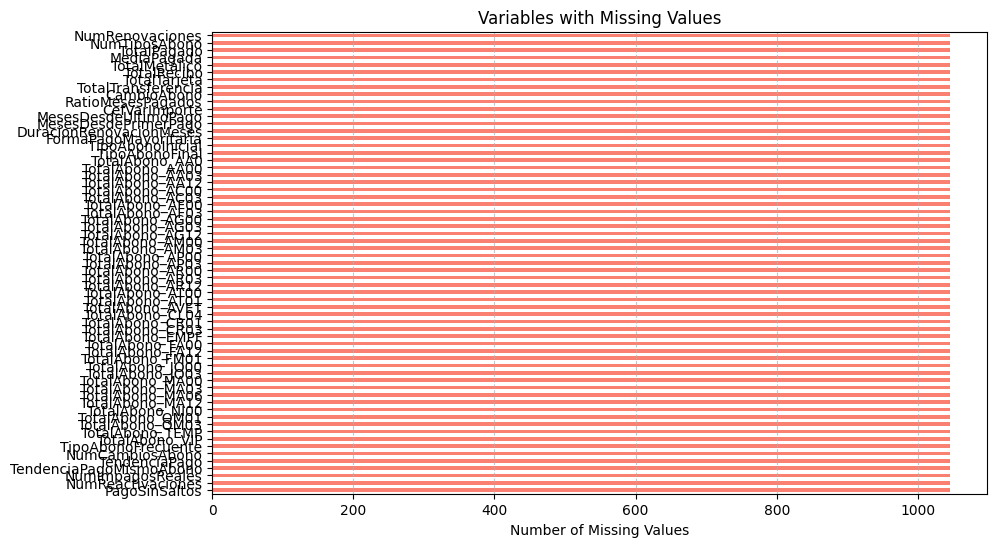

In [143]:
# 4. Variables with missing values
    # Detect columns with missing values and show the percentage
print("\n📌 Variables with missing values:")

# Count missing values by column
missing = union_economia_copy.isnull().sum()

# Filter only columns with missing values
missing = missing[missing > 0].sort_values(ascending=False)

# Calculate missing percentage
missing_percentage = (missing / len(union_economia_copy)) * 100

# Create a DataFrame to show the count and percentage of missing values
missing_df = pd.DataFrame({'Total Missing': missing, 'Percentage Missing': missing_percentage})

# If missing values exist, display a bar chart of missing values distribution
if not missing.empty:
    display(missing_df)
    plt.figure(figsize=(10, 6))
    missing.plot(kind='barh', color='salmon')  # Horizontal bar chart
    plt.title("Variables with Missing Values")
    plt.xlabel("Number of Missing Values")
    plt.gca().invert_yaxis()  # Invert y-axis to show variables with most missing values first
    plt.grid(True, axis='x', linestyle='--', alpha=0.7)  # Add grid to the chart
    plt.show()
else:
    print("✅ No missing values in the dataset.")


Tratamiento columnas categoricas


In [147]:
categorical_cols = [
    'FormaPagoMayoritaria',
    'TipoAbonoInicial',
    'TipoAbonoFinal',
    'TipoAbonoFrecuente'
]

union_economia_copy[categorical_cols] = union_economia_copy[categorical_cols].fillna('Indefinido')


Tratamientos de los totales de pagos para abono 

In [ ]:
abono_cols = [col for col in union_economia_copy.columns if col.startswith('TotalAbono_')]
union_economia_copy[abono_cols] = union_economia_copy[abono_cols].fillna(0)

Tratamiento de la columna PagoSinSaltos

In [150]:
union_economia_copy['PagoSinSaltos'].unique()

array([ 0.,  1., nan])

In [152]:
# Asigna -1 a los que no tienen datos económicos
sin_datos_economicos = union_economia_copy['TotalPagado'].isna()
union_economia_copy.loc[sin_datos_economicos, 'PagoSinSaltos'] = -1

In [153]:
union_economia_copy['PagoSinSaltos'].unique()

array([ 0.,  1., -1.])

In [154]:
union_economia_copy['PagoSinSaltos'] = union_economia_copy['PagoSinSaltos'].map({
    -1: 'no_aplica',
    0: 'irregular',
    1: 'regular'
})

In [155]:
union_economia_copy = pd.get_dummies(union_economia_copy, columns=['PagoSinSaltos'], prefix='PagoSinSaltos')

Tratamiento de columnas numericas 

In [ ]:
cols_a_0 = [
    'NumRenovaciones',
    'NumTiposAbono',
    'TotalPagado',
    'MediaPagada',
    'TotalMetálico',
    'TotalRecibo',
    'TotalTarjeta',
    'TotalTransferencia',
    'CambioAbono',
    'RatioMesesPagados',
    'CefVarImporte',
    'MesesDesdeUltimoPago'   ,
    'MesesDesdePrimerPago',
    'DuracionRenovacionMeses',
    'NumCambiosAbono',
    'TendenciaPago',
    'TendenciaPagoMismoAbono',
    'NumImpagosReales',
    'NumReactivaciones',
]

union_economia_copy[cols_a_0] = union_economia_copy[cols_a_0].fillna(0)

-POST

In [162]:
# 4. Variables with missing values
    # Detect columns with missing values and show the percentage
print("\n📌 Variables with missing values:")

# Count missing values by column
missing = union_economia_copy.isnull().sum()

# Filter only columns with missing values
missing = missing[missing > 0].sort_values(ascending=False)

# Calculate missing percentage
missing_percentage = (missing / len(union_economia_copy)) * 100

# Create a DataFrame to show the count and percentage of missing values
missing_df = pd.DataFrame({'Total Missing': missing, 'Percentage Missing': missing_percentage})

# If missing values exist, display a bar chart of missing values distribution
if not missing.empty:
    display(missing_df)
    plt.figure(figsize=(10, 6))
    missing.plot(kind='barh', color='salmon')  # Horizontal bar chart
    plt.title("Variables with Missing Values")
    plt.xlabel("Number of Missing Values")
    plt.gca().invert_yaxis()  # Invert y-axis to show variables with most missing values first
    plt.grid(True, axis='x', linestyle='--', alpha=0.7)  # Add grid to the chart
    plt.show()
else:
    print("✅ No missing values in the dataset.")


📌 Variables with missing values:
✅ No missing values in the dataset.


In [ ]:
union_economia_copy

,IdPersona,Edad,Sexo_Mujer,Churn,AntiguedadAños,TipoUltimoAbono,Irregularidad_ActivoIrregular,Irregularidad_ActivoRegular,Irregularidad_BajaFinalIrregular,Irregularidad_BajaFinalRegular,MesesDesdeUltimoAbono,Importe_2024_servicios,Cantidad_2024_servicios,Importe_2025_servicios,Cantidad_2025_servicios,Importe_total_pagado_servicios,Cantidad_total_pagado_servicios,Concepto_ENTRENADOR PERSONAL 1 /2 SESSIO ABONAT,Concepto_ENTRENADOR PERSONAL 1 SESSIO,Concepto_ENTRENADOR PERSONAL 1 SESSIÓ ABONAT,Concepto_ENTRENADOR PERSONAL 10 (30 MINUTS),Concepto_ENTRENADOR PERSONAL 10 (30 MINUTS) ABONAT,Concepto_ENTRENADOR PERSONAL 10 SESSIONS ABONAT,Concepto_ENTRENADOR PERSONAL 5 (30 MINUTS) ABONAT,Concepto_ENTRENADOR PERSONAL 5 SESSIONS ABONAT,Concepto_FISIO ABONAMENT 10 SESSIONS 60' ABONAT,Concepto_FISIO ABONAMENT 5 SESSIONS 30' ABONAT,Concepto_FISIO ABONAMENT 5 SESSIONS 60',Concepto_FISIO PACK BENVINGUDA,Concepto_FISIOTERÀPIA 60' ABONAT,Concepto_FISIOTERÀPIA 30' ABONAT,Concepto_NUTRI ANTROPOMETRIA,Concepto_NUTRI ANTROPOMETRIA ABONAT,Concepto_NUTRI PACK 3 SEGUIMENTS ABONAT,Concepto_NUTRI VISITA DE SEGUIMENT ABONAT,Concepto_PACK 3 SEGUIMENTS ABONAT,Concepto_PACK NUTRICIÓ (2 VISITES) ABONAT,TipoServicio_ENTRENAMENTS PERSONALS,TipoServicio_FISIOTERÀPIA,TipoServicio_NUTRICIÓ,Total_conceptos_unicos,Total_tipos_servicios_unicos,UsoServiciosExtra,NumRenovaciones,NumTiposAbono,TotalPagado,MediaPagada,TotalMetálico,TotalRecibo,TotalTarjeta,TotalTransferencia,CambioAbono,RatioMesesPagados,CefVarImporte,MesesDesdeUltimoPago,MesesDesdePrimerPago,DuracionRenovacionMeses,FormaPagoMayoritaria,TipoAbonoInicial,TipoAbonoFinal,TotalAbono_AA0,TotalAbono_AA00,TotalAbono_AA03,TotalAbono_AA12,TotalAbono_AC00,TotalAbono_AC03,TotalAbono_AF00,TotalAbono_AF03,TotalAbono_AG00,TotalAbono_AG03,TotalAbono_AG12,TotalAbono_AM00,TotalAbono_AM03,TotalAbono_AP00,TotalAbono_AP03,TotalAbono_AR00,TotalAbono_AR03,TotalAbono_AR12,TotalAbono_AT00,TotalAbono_AT01,TotalAbono_AVET,TotalAbono_CL04,TotalAbono_CR01,TotalAbono_CR03,TotalAbono_EMPF,TotalAbono_FA00,TotalAbono_FA12,TotalAbono_FM01,TotalAbono_JO00,TotalAbono_JO03,TotalAbono_MA00,TotalAbono_MA03,TotalAbono_MA06,TotalAbono_MA12,TotalAbono_NI00,TotalAbono_QM01,TotalAbono_QM03,TotalAbono_TEMP,TotalAbono_VIP,TipoAbonoFrecuente,NumCambiosAbono,TendenciaPago,TendenciaPagoMismoAbono,NumImpagosReales,NumReactivaciones,TienePagos,PagoSinSaltos_irregular,PagoSinSaltos_no_aplica,PagoSinSaltos_regular
0,334,82.0,False,0,69.81,AVET,True,False,False,False,175.9,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.0,0.0,0.0,0.0,0.0,False,2.0,1.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.166667,0.0,1.0,7.0,5.946124,Metálico,AVET,AVET,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AVET,0.0,0.0,0.0,1.0,0.0,True,True,False,False
1,452,85.0,False,0,69.00,AVET,False,True,False,False,839.5,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.0,0.0,0.0,0.0,0.0,False,2.0,1.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.166667,0.0,1.0,7.0,5.946124,Metálico,AVET,AVET,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AVET,0.0,0.0,0.0,1.0,0.0,True,True,False,False
2,642,77.0,False,0,67.54,AVET,True,False,False,False,175.9,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.0,0.0,0.0,0.0,0.0,False,2.0,1.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.166667,0.0,1.0,7.0,5.946124,Metálico,AVET,AVET,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AVET,0.0,0.0,0.0,1.0,0.0,True,True,False,False
3,849,

# TERCERA PARTE: ABONADOS, SERVICIOS EXTRA Y ECONOMIA + ACCESOS TOTALES

In [166]:
union_economia_copy.head()

,IdPersona,Edad,Sexo_Mujer,Churn,AntiguedadAños,TipoUltimoAbono,Irregularidad_ActivoIrregular,Irregularidad_ActivoRegular,Irregularidad_BajaFinalIrregular,Irregularidad_BajaFinalRegular,MesesDesdeUltimoAbono,Importe_2024_servicios,Cantidad_2024_servicios,Importe_2025_servicios,Cantidad_2025_servicios,Importe_total_pagado_servicios,Cantidad_total_pagado_servicios,Concepto_ENTRENADOR PERSONAL 1 /2 SESSIO ABONAT,Concepto_ENTRENADOR PERSONAL 1 SESSIO,Concepto_ENTRENADOR PERSONAL 1 SESSIÓ ABONAT,Concepto_ENTRENADOR PERSONAL 10 (30 MINUTS),Concepto_ENTRENADOR PERSONAL 10 (30 MINUTS) ABONAT,Concepto_ENTRENADOR PERSONAL 10 SESSIONS ABONAT,Concepto_ENTRENADOR PERSONAL 5 (30 MINUTS) ABONAT,Concepto_ENTRENADOR PERSONAL 5 SESSIONS ABONAT,Concepto_FISIO ABONAMENT 10 SESSIONS 60' ABONAT,Concepto_FISIO ABONAMENT 5 SESSIONS 30' ABONAT,Concepto_FISIO ABONAMENT 5 SESSIONS 60',Concepto_FISIO PACK BENVINGUDA,Concepto_FISIOTERÀPIA 60' ABONAT,Concepto_FISIOTERÀPIA 30' ABONAT,Concepto_NUTRI ANTROPOMETRIA,Concepto_NUTRI ANTROPOMETRIA ABONAT,Concepto_NUTRI PACK 3 SEGUIMENTS ABONAT,Concepto_NUTRI VISITA DE SEGUIMENT ABONAT,Concepto_PACK 3 SEGUIMENTS ABONAT,Concepto_PACK NUTRICIÓ (2 VISITES) ABONAT,TipoServicio_ENTRENAMENTS PERSONALS,TipoServicio_FISIOTERÀPIA,TipoServicio_NUTRICIÓ,Total_conceptos_unicos,Total_tipos_servicios_unicos,UsoServiciosExtra,NumRenovaciones,NumTiposAbono,TotalPagado,MediaPagada,TotalMetálico,TotalRecibo,TotalTarjeta,TotalTransferencia,CambioAbono,RatioMesesPagados,CefVarImporte,MesesDesdeUltimoPago,MesesDesdePrimerPago,DuracionRenovacionMeses,FormaPagoMayoritaria,TipoAbonoInicial,TipoAbonoFinal,TotalAbono_AA0,TotalAbono_AA00,TotalAbono_AA03,TotalAbono_AA12,TotalAbono_AC00,TotalAbono_AC03,TotalAbono_AF00,TotalAbono_AF03,TotalAbono_AG00,TotalAbono_AG03,TotalAbono_AG12,TotalAbono_AM00,TotalAbono_AM03,TotalAbono_AP00,TotalAbono_AP03,TotalAbono_AR00,TotalAbono_AR03,TotalAbono_AR12,TotalAbono_AT00,TotalAbono_AT01,TotalAbono_AVET,TotalAbono_CL04,TotalAbono_CR01,TotalAbono_CR03,TotalAbono_EMPF,TotalAbono_FA00,TotalAbono_FA12,TotalAbono_FM01,TotalAbono_JO00,TotalAbono_JO03,TotalAbono_MA00,TotalAbono_MA03,TotalAbono_MA06,TotalAbono_MA12,TotalAbono_NI00,TotalAbono_QM01,TotalAbono_QM03,TotalAbono_TEMP,TotalAbono_VIP,TipoAbonoFrecuente,NumCambiosAbono,TendenciaPago,TendenciaPagoMismoAbono,NumImpagosReales,NumReactivaciones,TienePagos,PagoSinSaltos_irregular,PagoSinSaltos_no_aplica,PagoSinSaltos_regular
0,334,82.0,False,0,69.81,AVET,True,False,False,False,175.9,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.0,0.0,0.0,0.0,0.0,False,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.0,1.0,7.0,5.946124,Metálico,AVET,AVET,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AVET,0.0,0.0,0.0,1.0,0.0,True,True,False,False
1,452,85.0,False,0,69.00,AVET,False,True,False,False,839.5,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.0,0.0,0.0,0.0,0.0,False,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.0,1.0,7.0,5.946124,Metálico,AVET,AVET,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AVET,0.0,0.0,0.0,1.0,0.0,True,True,False,False
2,642,77.0,False,0,67.54,AVET,True,False,False,False,175.9,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.0,0.0,0.0,0.0,0.0,False,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.0,1.0,7.0,5.946124,Metálico,AVET,AVET,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AVET,0.0,0.0,0.0,1.0,0.0,True,True,False,False
3,849,85.0,False,0

In [167]:
accesos.head()

,IdPersona,TotalVisitas,DiasActivo,VisitasPorSemana,VisitasPorMes,MaxVisitasDia,VarVisitasMes,DuracionMediaTotal,DuracionStdTotal,DuracionMediaUlt90,DeltaDuracionUlt90VsTotal,PropVisitasLargas,VisitasUlt30,VisitasUlt90,VisitasUlt180,PropUlt90,DiasDesdeUltima,DiasHastaPrimera,StdDiasEntreVisitas,FrecuenciaModal,SemanasConVisita,SemanasTotales,SemanasConUnaVisita,MaxRachaSinVisita,MaxRachaConVisita,HoraMediaAcceso,HoraStdAcceso,VarDiasSemana,PropFindesemana,PropPrimavera,PropVerano,PropOtono,PropInvierno,VisitasFestivos,PropVisitasFestivos,VisitasFindesemana,PropVisitasFindesemana,VisitasCerrado,PropVisitasCerrado,VisitasRed9a14,PropVisitasRed9a14,VisitasRed7a20,PropVisitasRed7a20,VisitasRed7a15,PropVisitasRed7a15,PrimeraVisita,UltimaVisita,TiempoActivoDias,VisitasPrimerTrimestre,VisitasUltimoTrimestre,DiaFav_domingo,DiaFav_jueves,DiaFav_lunes,DiaFav_martes,DiaFav_miércoles,DiaFav_sábado,DiaFav_viernes,EstFav_invierno,EstFav_otono,EstFav_primavera,EstFav_verano
0,334,3,3,1.500000,2.432432,1,0.000000,50.422222,8.675597,50.422222,0.000000,0.333333,3,3,3,1.000000,383,9,1.500000,2.0,2,2,1,5.0,1,11.144444,0.452224,0.530612,0.000000,0.000000,0.000000,1.000000,0.000000,0,0.000000,0,0.000000,0,0.0,0,0.000000,0,0.0,0,0.0,2024-09-10,2024-09-17,7,3,3,False,False,False,True,False,False,False,False,True,False,False
1,2476,4,4,0.444444,1.395349,1,0.222222,81.408333,20.670257,81.408333,0.000000,1.000000,2,4,4,1.000000,45,298,4.642796,14.0,4,9,4,25.0,1,9.487500,0.967268,1.102041,0.000000,0.000000,1.000000,0.000000,0.000000,0,0.000000,0,0.000000,0,0.0,0,0.000000,0,0.0,0,0.0,2025-06-26,2025-08-21,56,4,4,False,True,False,False,False,False,False,False,False,False,True
2,2926,4,4,0.417910,1.333333,1,0.222222,40.066667,56.319974,40.066667,0.000000,0.250000,1,4,4,1.000000,292,47,14.514361,6.0,4,9,4,40.0,1,15.662500,2.937931,0.530612,0.000000,0.000000,0.000000,0.750000,0.250000,0,0.000000,0,0.000000,0,0.0,0,0.000000,0,0.0,0,0.0,2024-10-18,2024-12-17,60,4,4,False,True,False,False,False,False,False,False,True,False,False
3,3461,36,35,0.690411,2.783505,2,11.777778,95.457407,29.569428,117.154167,0.227293,0.916667,2,4,5,0.111111,34,7,23.910650,1.0,15,52,4,116.0,6,9.173611,0.696900,4.693878,0.166667,0.027778,0.083333,0.527778,0.361111,1,0.027778,6,0.166667,0,0.0,0,0.000000,0,0.0,0,0.0,2024-09-08,2025-09-01,358,18,4,False,False,True,False,False,False,False,False,True,False,False
4,4016,61,60,1.252199,5.027473,2,18.617284,83.150820,13.631576,88.990741,0.070233,0.983607,11,18,39,0.295082,40,25,14.171999,1.0,26,48,6,103.0,3,12.221585,2.043097,22.775510,0.081967,0.327869,0.295082,0.032787,0.344262,1,0.016393,5,0.081967,0,0.0,2,0.032787,0,0.0,0,0.0,2024-09-26,2025-08-26,334,2,18,False,False,True,False,False,False,False,True,False,False,False


In [168]:
accesos['TieneAccesos'] = True

#### UNIÓN DATAFRAMES POR ID DE PERSONA

In [241]:
union_accesos_resto= pd.merge(union_economia_copy, accesos, on='IdPersona', how='left')
union_accesos_resto

,IdPersona,Edad,Sexo_Mujer,Churn,AntiguedadAños,TipoUltimoAbono,Irregularidad_ActivoIrregular,Irregularidad_ActivoRegular,Irregularidad_BajaFinalIrregular,Irregularidad_BajaFinalRegular,MesesDesdeUltimoAbono,Importe_2024_servicios,Cantidad_2024_servicios,Importe_2025_servicios,Cantidad_2025_servicios,Importe_total_pagado_servicios,Cantidad_total_pagado_servicios,Concepto_ENTRENADOR PERSONAL 1 /2 SESSIO ABONAT,Concepto_ENTRENADOR PERSONAL 1 SESSIO,Concepto_ENTRENADOR PERSONAL 1 SESSIÓ ABONAT,Concepto_ENTRENADOR PERSONAL 10 (30 MINUTS),Concepto_ENTRENADOR PERSONAL 10 (30 MINUTS) ABONAT,Concepto_ENTRENADOR PERSONAL 10 SESSIONS ABONAT,Concepto_ENTRENADOR PERSONAL 5 (30 MINUTS) ABONAT,Concepto_ENTRENADOR PERSONAL 5 SESSIONS ABONAT,Concepto_FISIO ABONAMENT 10 SESSIONS 60' ABONAT,Concepto_FISIO ABONAMENT 5 SESSIONS 30' ABONAT,Concepto_FISIO ABONAMENT 5 SESSIONS 60',Concepto_FISIO PACK BENVINGUDA,Concepto_FISIOTERÀPIA 60' ABONAT,Concepto_FISIOTERÀPIA 30' ABONAT,Concepto_NUTRI ANTROPOMETRIA,Concepto_NUTRI ANTROPOMETRIA ABONAT,Concepto_NUTRI PACK 3 SEGUIMENTS ABONAT,Concepto_NUTRI VISITA DE SEGUIMENT ABONAT,Concepto_PACK 3 SEGUIMENTS ABONAT,Concepto_PACK NUTRICIÓ (2 VISITES) ABONAT,TipoServicio_ENTRENAMENTS PERSONALS,TipoServicio_FISIOTERÀPIA,TipoServicio_NUTRICIÓ,Total_conceptos_unicos,Total_tipos_servicios_unicos,UsoServiciosExtra,NumRenovaciones,NumTiposAbono,TotalPagado,MediaPagada,TotalMetálico,TotalRecibo,TotalTarjeta,TotalTransferencia,CambioAbono,RatioMesesPagados,CefVarImporte,MesesDesdeUltimoPago,MesesDesdePrimerPago,DuracionRenovacionMeses,FormaPagoMayoritaria,TipoAbonoInicial,TipoAbonoFinal,TotalAbono_AA0,TotalAbono_AA00,TotalAbono_AA03,TotalAbono_AA12,TotalAbono_AC00,TotalAbono_AC03,TotalAbono_AF00,TotalAbono_AF03,TotalAbono_AG00,TotalAbono_AG03,TotalAbono_AG12,TotalAbono_AM00,TotalAbono_AM03,TotalAbono_AP00,TotalAbono_AP03,TotalAbono_AR00,TotalAbono_AR03,TotalAbono_AR12,TotalAbono_AT00,TotalAbono_AT01,TotalAbono_AVET,TotalAbono_CL04,TotalAbono_CR01,TotalAbono_CR03,TotalAbono_EMPF,TotalAbono_FA00,TotalAbono_FA12,TotalAbono_FM01,TotalAbono_JO00,TotalAbono_JO03,TotalAbono_MA00,TotalAbono_MA03,TotalAbono_MA06,TotalAbono_MA12,TotalAbono_NI00,TotalAbono_QM01,TotalAbono_QM03,TotalAbono_TEMP,TotalAbono_VIP,TipoAbonoFrecuente,NumCambiosAbono,TendenciaPago,TendenciaPagoMismoAbono,NumImpagosReales,NumReactivaciones,TienePagos,PagoSinSaltos_irregular,PagoSinSaltos_no_aplica,PagoSinSaltos_regular,TotalVisitas,DiasActivo,VisitasPorSemana,VisitasPorMes,MaxVisitasDia,VarVisitasMes,DuracionMediaTotal,DuracionStdTotal,DuracionMediaUlt90,DeltaDuracionUlt90VsTotal,PropVisitasLargas,VisitasUlt30,VisitasUlt90,VisitasUlt180,PropUlt90,DiasDesdeUltima,DiasHastaPrimera,StdDiasEntreVisitas,FrecuenciaModal,SemanasConVisita,SemanasTotales,SemanasConUnaVisita,MaxRachaSinVisita,MaxRachaConVisita,HoraMediaAcceso,HoraStdAcceso,VarDiasSemana,PropFindesemana,PropPrimavera,PropVerano,PropOtono,PropInvierno,VisitasFestivos,PropVisitasFestivos,VisitasFindesemana,PropVisitasFindesemana,VisitasCerrado,PropVisitasCerrado,VisitasRed9a14,PropVisitasRed9a14,VisitasRed7a20,PropVisitasRed7a20,VisitasRed7a15,PropVisitasRed7a15,PrimeraVisita,UltimaVisita,TiempoActivoDias,VisitasPrimerTrimestre,VisitasUltimoTrimestre,DiaFav_domingo,DiaFav_jueves,DiaFav_lunes,DiaFav_martes,DiaFav_miércoles,DiaFav_sábado,DiaFav_viernes,EstFav_invierno,EstFav_otono,EstFav_primavera,EstFav_verano,TieneAccesos
0,334,82.0,False,0,69.81,AVET,True,False,False,False,175.9,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.0,0.0,0.0,0.0,0.0,False,2.0,1.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.166667,0.0,1.0,7.0,5.946124,Metálico,AVET,AVET,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AVET,0.0,0.0,0.0,1.0,0.0,True,True,False,False,3.0,3.0,1.500000,2.432432,1.0,0.00,50.422222,8.675597,50.422222,0.0,0.33

- Explicación de Variables

1. VOLUMEN DE USO

| Feature                | Tipo     | Interpretación                                                                      |
| ---------------------- | -------- | ----------------------------------------------------------------------------------- |
| `total_visitas`        | Numérico | Cuántas veces vino al gimnasio en todo el año. Básico para conocer su nivel de uso. |
| `dias_activo`          | Numérico | En cuántos días diferentes vino. Indica regularidad más que volumen puro.           |
| `visitas_semana_media` | Numérico | Promedio de visitas por semana. Bueno para comparar entre abonados.                 |
| `visitas_mes_media`    | Numérico | Media mensual. Refuerza la regularidad en otra escala temporal.                     |
| `max_visitas_dia`      | Numérico | Cuántas veces vino como máximo en un solo día (hay gente que viene 2 veces/día).    |
| `var_visitas_mes`      | Numérico | Variabilidad de uso mensual. Alta varianza puede significar interés inestable.      |


2. DURACIÓN DE LAS SESIONES

| Feature                                 | Interpretación                                         | 
| --------------------------------------- | --------------------------------------------------- 
| `duracion_media_total`               | Tiempo promedio por visita (min). Mide el compromiso global                    |
| `duracion_std_total`                  | Variabilidad en duración. Muestra si el hábito es estable o errático   |
| `duracion_media_ultimos_90_dias`    | Duración promedio en últimos 3 meses. Detecta si hay descenso o aumento reciente   |
| `delta_duracion_ultimos_90_vs_total`  | Cambio relativo entre últimos 90 días y media total. Señala tendencias de abandono o recuperación |
| `proporcion_visitas_largas (>60 min)` | % de visitas largas (por ejemplo, > 1 hora). Indica nivel de compromiso fuerte            |


3. REGULARIDAD / HÁBITO

| Feature                     | Tipo     | Interpretación                                                                    |
| --------------------------- | -------- | --------------------------------------------------------------------------------- |
| `visitas_ultimos_30_dias`   | Numérico | Señal directa de actividad reciente. Muy útil para modelos de churn.              |
| `visitas_ultimos_90_dias`   | Numérico | Evalúa si mantiene el ritmo en los últimos 3 meses.                               |
| `visitas_ultimos_180_dias`  | Numérico | Ayuda a identificar tendencias más suaves (semestre).                             |
| `proporcion_ultimos_90`     | Numérico | % de visitas recientes respecto al total. Si es bajo, puede estar alejándose.     |
| `dias_desde_ultima_visita`  | Numérico | Cuánto tiempo lleva sin venir. Cuanto más alto, mayor riesgo de baja.             |
| `dias_hasta_primera_visita` | Numérico | Si se apuntó y tardó mucho en venir, puede haber sido desinterés desde el inicio. |


| Feature                       | Tipo     | Interpretación                                                                     |
| ----------------------------- | -------- | ---------------------------------------------------------------------------------- |
| `std_dias_entre_visitas`      | Numérico | Desviación estándar de días entre visitas. Mide si su patrón es estable o caótico. |
| `frecuencia_modal`            | Numérico | Cada cuántos días suele venir (modo). Ayuda a entender periodicidad.               |
| `n_semanas_con_visita`        | Numérico | De las 52 semanas, en cuántas vino al menos una vez. Cuanto más alto, más regular. |
| `semanas_con_una_sola_visita` | Numérico | Señal de compromiso bajo o intermitente.                                           |
| `racha_max_sin_visitar`       | Numérico | Máximo de días consecutivos sin venir. Picos largos son señales de riesgo.         |
| `racha_max_con_visita`        | Numérico | Días consecutivos viniendo. Picos largos son señales de alto engagement.           |


4. DISTRIBUCIÓN TEMPORAL – HORAS Y DÍAS

| Feature                         | Tipo       | Interpretación                                                                           |
| ------------------------------- | ---------- | ---------------------------------------------------------------------------------------- |
| `hora_media_acceso`             | Numérico   | Hora promedio de entrada (en decimal, ej. 8.5 = 8:30). Ayuda a clasificar perfiles.      |
| `hora_std_acceso`               | Numérico   | Variabilidad horaria: si es muy baja, tiene hábitos fijos.                               |
| `dia_favorito`                  | Categórica | Día con más accesos. Puedes agrupar por tipo de usuario.                                 |
| `var_dias_semana`               | Numérico   | Varianza de visitas entre días de la semana. Alta = no tiene hábito fijo.                |
| `proporcion_finde`              | Numérico   | % de visitas en sábados y domingos. Útil para segmentar clientes más "ocasionales".      |


5. ESTACIONALIDAD

| Feature                                    | Tipo       | Interpretación                                                                                |
| ------------------------------------------ | ---------- | --------------------------------------------------------------------------------------------- |
| `primavera`, `verano`, `otono`, `invierno` | Numéricos  | Número de visitas por estación. Sirve para ver si hay cambios de hábitos estacionales.        |
| `estacion_favorita`                        | Categórica | Estación con más visitas. Útil para segmentar clientes según motivaciones (ej. "verano fit"). |
| `prop_primavera` a `prop_invierno`         | Numéricos  | % de visitas en cada estación. Ayuda a entender el peso temporal del uso.                     |


6. DÍAS ESPECIALES (Festivos, cierres, horarios especiales)

| Feature                                     | Tipo      | Interpretación                                                                        |
| ------------------------------------------- | --------- | ------------------------------------------------------------------------------------- |
| `visitas_en_festivos`                       | Numérico  | ¿Viene en días festivos? Algunos lo hacen por tener más tiempo.                       |
| `visitas_en_finde`                          | Numérico  | Visitas en sábado y domingo.                                                          |
| `visitas_en_dias_cerrados`                  | Numérico  | Errores o visitas inesperadas (deberían ser 0, salvo errores de sistema).             |
| `visitas_en_reduccion_9_14`, `7_20`, `7_15` | Numéricos | Cuántas veces vino en días con horarios reducidos. Muestra flexibilidad o compromiso. |


7. PRIMERAS Y ÚLTIMAS VISITAS

| Feature                    | Tipo     | Interpretación                                        |
| -------------------------- | -------- | ----------------------------------------------------- |
| `primera_visita`           | Fecha    | Cuándo empezó realmente a usar el gimnasio.           |
| `ultima_visita`            | Fecha    | Última vez que vino.                                  |
| `tiempo_activo`            | Numérico | Cuántos días estuvo “activo” (última - primera).      |
| `visitas_primer_trimestre` | Numérico | Para analizar su arranque.                            |
| `visitas_ultimo_trimestre` | Numérico | Para analizar si ha bajado el ritmo (señal de churn). |


#### TRATAMIENTO DATAFRAME UNIDO

In [243]:
union_accesos= union_accesos_resto.copy()

In [244]:
union_accesos['TieneAccesos'] = union_accesos['TieneAccesos'].fillna(False)

In [245]:
union_accesos['Churn'].value_counts()

Churn
0    4941
1    3244
Name: count, dtype: int64

#### ¿Hay Nulos?

-PRE


📌 Variables with missing values:


,Total Missing,Percentage Missing
TotalVisitas,1457,17.800855
DiasActivo,1457,17.800855
VisitasPorSemana,1457,17.800855
VisitasPorMes,1457,17.800855
MaxVisitasDia,1457,17.800855
VarVisitasMes,1457,17.800855
DuracionMediaTotal,1457,17.800855
DuracionStdTotal,1457,17.800855
DuracionMediaUlt90,1457,17.800855
DeltaDuracionUlt90VsTotal,1457,17.800855


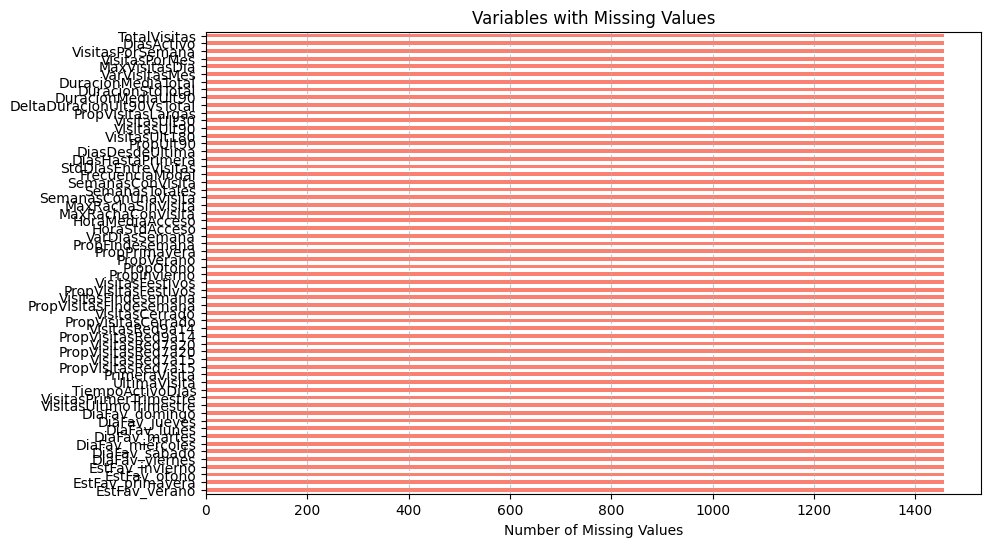

In [246]:
# 4. Variables with missing values
    # Detect columns with missing values and show the percentage
print("\n📌 Variables with missing values:")

# Count missing values by column
missing = union_accesos.isnull().sum()

# Filter only columns with missing values
missing = missing[missing > 0].sort_values(ascending=False)

# Calculate missing percentage
missing_percentage = (missing / len(union_accesos)) * 100

# Create a DataFrame to show the count and percentage of missing values
missing_df = pd.DataFrame({'Total Missing': missing, 'Percentage Missing': missing_percentage})

# If missing values exist, display a bar chart of missing values distribution
if not missing.empty:
    display(missing_df)
    plt.figure(figsize=(10, 6))
    missing.plot(kind='barh', color='salmon')  # Horizontal bar chart
    plt.title("Variables with Missing Values")
    plt.xlabel("Number of Missing Values")
    plt.gca().invert_yaxis()  # Invert y-axis to show variables with most missing values first
    plt.grid(True, axis='x', linestyle='--', alpha=0.7)  # Add grid to the chart
    plt.show()
else:
    print("✅ No missing values in the dataset.")

In [247]:
# Identificar columnas tipo flag (día favorito y estación favorita)
columnas_flags = [col for col in union_accesos.columns if col.startswith('DiaFav_') or col.startswith('EstFav_')]

# Rellenar NaN con False
union_accesos[columnas_flags] = union_accesos[columnas_flags].fillna(False)

In [ ]:
cols_a_0 = [
    'TotalVisitas',
    'DiasActivo',
    'VisitasPorSemana',
    'VisitasPorMes',
    'MaxVisitasDia',
    'VarVisitasMes',
    'PropVisitasLargas',
    'VisitasUlt30'	,
    'VisitasUlt90',	
    'VisitasUlt180',	
    'PropUlt90',
    'DiasDesdeUltima'	,
    'DiasHastaPrimera'	,
    'StdDiasEntreVisitas',
    'FrecuenciaModal'	,
    'SemanasConVisita',	
    'SemanasTotales',
    'SemanasConUnaVisita',
    'MaxRachaSinVisita'	,
    'MaxRachaConVisita',
    'VarDiasSemana',
    'PropFindesemana',
    'PropPrimavera',
    'PropVerano'	,
    'PropOtono',	
    'PropInvierno',
    'VisitasCerrado',
    'PropVisitasCerrado',
    'VisitasRed9a14'	,
    'PropVisitasRed9a14',	
    'VisitasRed7a20',	
    'PropVisitasRed7a20',	
    'VisitasRed7a15'	,
    'PropVisitasRed7a15',
    'TiempoActivoDias',
    'VisitasPrimerTrimestre',
    'VisitasUltimoTrimestre',
    'HoraMediaAcceso',	
    'HoraStdAcceso',
    'VisitasFindesemana'	,
    'PropVisitasFindesemana',
    'VisitasFestivos',
    'PropVisitasFestivos',
    'DuracionMediaTotal',
    'DuracionStdTotal',
    'DuracionMediaUlt90',
    'DeltaDuracionUlt90VsTotal'
]

union_accesos[cols_a_0] = union_accesos[cols_a_0].fillna(0)



-POST


📌 Variables with missing values:


,Total Missing,Percentage Missing
PrimeraVisita,1457,17.800855
UltimaVisita,1457,17.800855


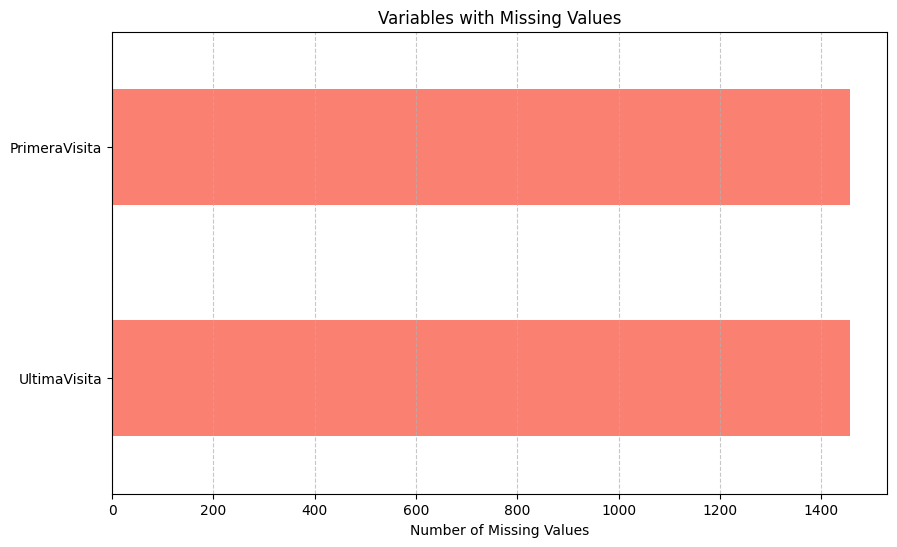

In [251]:
# 4. Variables with missing values
    # Detect columns with missing values and show the percentage
print("\n📌 Variables with missing values:")

# Count missing values by column
missing = union_accesos.isnull().sum()

# Filter only columns with missing values
missing = missing[missing > 0].sort_values(ascending=False)

# Calculate missing percentage
missing_percentage = (missing / len(union_accesos)) * 100

# Create a DataFrame to show the count and percentage of missing values
missing_df = pd.DataFrame({'Total Missing': missing, 'Percentage Missing': missing_percentage})

# If missing values exist, display a bar chart of missing values distribution
if not missing.empty:
    display(missing_df)
    plt.figure(figsize=(10, 6))
    missing.plot(kind='barh', color='salmon')  # Horizontal bar chart
    plt.title("Variables with Missing Values")
    plt.xlabel("Number of Missing Values")
    plt.gca().invert_yaxis()  # Invert y-axis to show variables with most missing values first
    plt.grid(True, axis='x', linestyle='--', alpha=0.7)  # Add grid to the chart
    plt.show()
else:
    print("✅ No missing values in the dataset.")

Como ya se han creado columnas derivadas a las columnas PrimeraVisita y UltimaVisita se decide precendir de ellas ya que son fechas y para el modelo no es correcto

In [252]:
union_accesos= union_accesos.drop(columns=['PrimeraVisita', 'UltimaVisita'])

Verificamos si hemos borrado todos los nulos correctamente después de eliminar las columnas anteriores

In [253]:
nulos = union_accesos.isnull().sum()
nulos[nulos > 0].sort_values(ascending=False)

Series([], dtype: int64)

### ¿Hay duplicados?

In [257]:
print("\n🔍 Duplicate Rows:")

# Count how many rows are duplicates
duplicated_rows = union_accesos.duplicated().sum()
if duplicated_rows > 0:
    print("🔴 Duplicate Rows:")
    display(union_accesos[union_accesos.duplicated()])  # Show duplicate rows
else:
    print('No duplicate rows')

# Check for duplicate columns
print("\n🔍 Duplicate Columns:")

# Transpose the abonado_altasFrame to check for duplicate columns
duplicated_columns = union_accesos.T.duplicated().sum()
if duplicated_columns > 0:
    display(union_accesos[union_accesos.duplicated()])  # Show duplicate columns
else:
    print('No duplicate columns')


🔍 Duplicate Rows:
No duplicate rows

🔍 Duplicate Columns:


,IdPersona,Edad,Sexo_Mujer,Churn,AntiguedadAños,TipoUltimoAbono,Irregularidad_ActivoIrregular,Irregularidad_ActivoRegular,Irregularidad_BajaFinalIrregular,Irregularidad_BajaFinalRegular,MesesDesdeUltimoAbono,Importe_2024_servicios,Cantidad_2024_servicios,Importe_2025_servicios,Cantidad_2025_servicios,Importe_total_pagado_servicios,Cantidad_total_pagado_servicios,Concepto_ENTRENADOR PERSONAL 1 /2 SESSIO ABONAT,Concepto_ENTRENADOR PERSONAL 1 SESSIO,Concepto_ENTRENADOR PERSONAL 1 SESSIÓ ABONAT,Concepto_ENTRENADOR PERSONAL 10 (30 MINUTS),Concepto_ENTRENADOR PERSONAL 10 (30 MINUTS) ABONAT,Concepto_ENTRENADOR PERSONAL 10 SESSIONS ABONAT,Concepto_ENTRENADOR PERSONAL 5 (30 MINUTS) ABONAT,Concepto_ENTRENADOR PERSONAL 5 SESSIONS ABONAT,Concepto_FISIO ABONAMENT 10 SESSIONS 60' ABONAT,Concepto_FISIO ABONAMENT 5 SESSIONS 30' ABONAT,Concepto_FISIO ABONAMENT 5 SESSIONS 60',Concepto_FISIO PACK BENVINGUDA,Concepto_FISIOTERÀPIA 60' ABONAT,Concepto_FISIOTERÀPIA 30' ABONAT,Concepto_NUTRI ANTROPOMETRIA,Concepto_NUTRI ANTROPOMETRIA ABONAT,Concepto_NUTRI PACK 3 SEGUIMENTS ABONAT,Concepto_NUTRI VISITA DE SEGUIMENT ABONAT,Concepto_PACK 3 SEGUIMENTS ABONAT,Concepto_PACK NUTRICIÓ (2 VISITES) ABONAT,TipoServicio_ENTRENAMENTS PERSONALS,TipoServicio_FISIOTERÀPIA,TipoServicio_NUTRICIÓ,Total_conceptos_unicos,Total_tipos_servicios_unicos,UsoServiciosExtra,NumRenovaciones,NumTiposAbono,TotalPagado,MediaPagada,TotalMetálico,TotalRecibo,TotalTarjeta,TotalTransferencia,CambioAbono,RatioMesesPagados,CefVarImporte,MesesDesdeUltimoPago,MesesDesdePrimerPago,DuracionRenovacionMeses,FormaPagoMayoritaria,TipoAbonoInicial,TipoAbonoFinal,TotalAbono_AA0,TotalAbono_AA00,TotalAbono_AA03,TotalAbono_AA12,TotalAbono_AC00,TotalAbono_AC03,TotalAbono_AF00,TotalAbono_AF03,TotalAbono_AG00,TotalAbono_AG03,TotalAbono_AG12,TotalAbono_AM00,TotalAbono_AM03,TotalAbono_AP00,TotalAbono_AP03,TotalAbono_AR00,TotalAbono_AR03,TotalAbono_AR12,TotalAbono_AT00,TotalAbono_AT01,TotalAbono_AVET,TotalAbono_CL04,TotalAbono_CR01,TotalAbono_CR03,TotalAbono_EMPF,TotalAbono_FA00,TotalAbono_FA12,TotalAbono_FM01,TotalAbono_JO00,TotalAbono_JO03,TotalAbono_MA00,TotalAbono_MA03,TotalAbono_MA06,TotalAbono_MA12,TotalAbono_NI00,TotalAbono_QM01,TotalAbono_QM03,TotalAbono_TEMP,TotalAbono_VIP,TipoAbonoFrecuente,NumCambiosAbono,TendenciaPago,TendenciaPagoMismoAbono,NumImpagosReales,NumReactivaciones,TienePagos,PagoSinSaltos_irregular,PagoSinSaltos_no_aplica,PagoSinSaltos_regular,TotalVisitas,DiasActivo,VisitasPorSemana,VisitasPorMes,MaxVisitasDia,VarVisitasMes,DuracionMediaTotal,DuracionStdTotal,DuracionMediaUlt90,DeltaDuracionUlt90VsTotal,PropVisitasLargas,VisitasUlt30,VisitasUlt90,VisitasUlt180,PropUlt90,DiasDesdeUltima,DiasHastaPrimera,StdDiasEntreVisitas,FrecuenciaModal,SemanasConVisita,SemanasTotales,SemanasConUnaVisita,MaxRachaSinVisita,MaxRachaConVisita,HoraMediaAcceso,HoraStdAcceso,VarDiasSemana,PropFindesemana,PropPrimavera,PropVerano,PropOtono,PropInvierno,VisitasFestivos,PropVisitasFestivos,VisitasFindesemana,PropVisitasFindesemana,VisitasCerrado,PropVisitasCerrado,VisitasRed9a14,PropVisitasRed9a14,VisitasRed7a20,PropVisitasRed7a20,VisitasRed7a15,PropVisitasRed7a15,TiempoActivoDias,VisitasPrimerTrimestre,VisitasUltimoTrimestre,DiaFav_domingo,DiaFav_jueves,DiaFav_lunes,DiaFav_martes,DiaFav_miércoles,DiaFav_sábado,DiaFav_viernes,EstFav_invierno,EstFav_otono,EstFav_primavera,EstFav_verano,TieneAccesos


In [254]:
union_accesos

,IdPersona,Edad,Sexo_Mujer,Churn,AntiguedadAños,TipoUltimoAbono,Irregularidad_ActivoIrregular,Irregularidad_ActivoRegular,Irregularidad_BajaFinalIrregular,Irregularidad_BajaFinalRegular,MesesDesdeUltimoAbono,Importe_2024_servicios,Cantidad_2024_servicios,Importe_2025_servicios,Cantidad_2025_servicios,Importe_total_pagado_servicios,Cantidad_total_pagado_servicios,Concepto_ENTRENADOR PERSONAL 1 /2 SESSIO ABONAT,Concepto_ENTRENADOR PERSONAL 1 SESSIO,Concepto_ENTRENADOR PERSONAL 1 SESSIÓ ABONAT,Concepto_ENTRENADOR PERSONAL 10 (30 MINUTS),Concepto_ENTRENADOR PERSONAL 10 (30 MINUTS) ABONAT,Concepto_ENTRENADOR PERSONAL 10 SESSIONS ABONAT,Concepto_ENTRENADOR PERSONAL 5 (30 MINUTS) ABONAT,Concepto_ENTRENADOR PERSONAL 5 SESSIONS ABONAT,Concepto_FISIO ABONAMENT 10 SESSIONS 60' ABONAT,Concepto_FISIO ABONAMENT 5 SESSIONS 30' ABONAT,Concepto_FISIO ABONAMENT 5 SESSIONS 60',Concepto_FISIO PACK BENVINGUDA,Concepto_FISIOTERÀPIA 60' ABONAT,Concepto_FISIOTERÀPIA 30' ABONAT,Concepto_NUTRI ANTROPOMETRIA,Concepto_NUTRI ANTROPOMETRIA ABONAT,Concepto_NUTRI PACK 3 SEGUIMENTS ABONAT,Concepto_NUTRI VISITA DE SEGUIMENT ABONAT,Concepto_PACK 3 SEGUIMENTS ABONAT,Concepto_PACK NUTRICIÓ (2 VISITES) ABONAT,TipoServicio_ENTRENAMENTS PERSONALS,TipoServicio_FISIOTERÀPIA,TipoServicio_NUTRICIÓ,Total_conceptos_unicos,Total_tipos_servicios_unicos,UsoServiciosExtra,NumRenovaciones,NumTiposAbono,TotalPagado,MediaPagada,TotalMetálico,TotalRecibo,TotalTarjeta,TotalTransferencia,CambioAbono,RatioMesesPagados,CefVarImporte,MesesDesdeUltimoPago,MesesDesdePrimerPago,DuracionRenovacionMeses,FormaPagoMayoritaria,TipoAbonoInicial,TipoAbonoFinal,TotalAbono_AA0,TotalAbono_AA00,TotalAbono_AA03,TotalAbono_AA12,TotalAbono_AC00,TotalAbono_AC03,TotalAbono_AF00,TotalAbono_AF03,TotalAbono_AG00,TotalAbono_AG03,TotalAbono_AG12,TotalAbono_AM00,TotalAbono_AM03,TotalAbono_AP00,TotalAbono_AP03,TotalAbono_AR00,TotalAbono_AR03,TotalAbono_AR12,TotalAbono_AT00,TotalAbono_AT01,TotalAbono_AVET,TotalAbono_CL04,TotalAbono_CR01,TotalAbono_CR03,TotalAbono_EMPF,TotalAbono_FA00,TotalAbono_FA12,TotalAbono_FM01,TotalAbono_JO00,TotalAbono_JO03,TotalAbono_MA00,TotalAbono_MA03,TotalAbono_MA06,TotalAbono_MA12,TotalAbono_NI00,TotalAbono_QM01,TotalAbono_QM03,TotalAbono_TEMP,TotalAbono_VIP,TipoAbonoFrecuente,NumCambiosAbono,TendenciaPago,TendenciaPagoMismoAbono,NumImpagosReales,NumReactivaciones,TienePagos,PagoSinSaltos_irregular,PagoSinSaltos_no_aplica,PagoSinSaltos_regular,TotalVisitas,DiasActivo,VisitasPorSemana,VisitasPorMes,MaxVisitasDia,VarVisitasMes,DuracionMediaTotal,DuracionStdTotal,DuracionMediaUlt90,DeltaDuracionUlt90VsTotal,PropVisitasLargas,VisitasUlt30,VisitasUlt90,VisitasUlt180,PropUlt90,DiasDesdeUltima,DiasHastaPrimera,StdDiasEntreVisitas,FrecuenciaModal,SemanasConVisita,SemanasTotales,SemanasConUnaVisita,MaxRachaSinVisita,MaxRachaConVisita,HoraMediaAcceso,HoraStdAcceso,VarDiasSemana,PropFindesemana,PropPrimavera,PropVerano,PropOtono,PropInvierno,VisitasFestivos,PropVisitasFestivos,VisitasFindesemana,PropVisitasFindesemana,VisitasCerrado,PropVisitasCerrado,VisitasRed9a14,PropVisitasRed9a14,VisitasRed7a20,PropVisitasRed7a20,VisitasRed7a15,PropVisitasRed7a15,TiempoActivoDias,VisitasPrimerTrimestre,VisitasUltimoTrimestre,DiaFav_domingo,DiaFav_jueves,DiaFav_lunes,DiaFav_martes,DiaFav_miércoles,DiaFav_sábado,DiaFav_viernes,EstFav_invierno,EstFav_otono,EstFav_primavera,EstFav_verano,TieneAccesos
0,334,82.0,False,0,69.81,AVET,True,False,False,False,175.9,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.0,0.0,0.0,0.0,0.0,False,2.0,1.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.166667,0.0,1.0,7.0,5.946124,Metálico,AVET,AVET,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AVET,0.0,0.0,0.0,1.0,0.0,True,True,False,False,3.0,3.0,1.500000,2.432432,1.0,0.00,50.422222,8.675597,50.422222,0.0,0.333333,3.0,3.0,3.0,1.0,383.0,

# GUARDAMOS DATAFRAME RESULTANTE 

In [258]:
# Guardar el DataFrame en un archivo CSV
union_accesos.to_csv('../data/dataframe_final_abonado.csv', index=False)